## Setup & Data

We’ll simulate 100 observations from a Normal(μ=5, σ²=4) and import what we need.


(array([ 1.,  5.,  7., 13., 17., 18., 16., 11.,  7.,  5.]),
 array([-0.10597963,  0.85856926,  1.82311814,  2.78766703,  3.75221592,
         4.71676481,  5.6813137 ,  6.64586258,  7.61041147,  8.57496036,
         9.53950925]),
 <BarContainer object of 10 artists>)

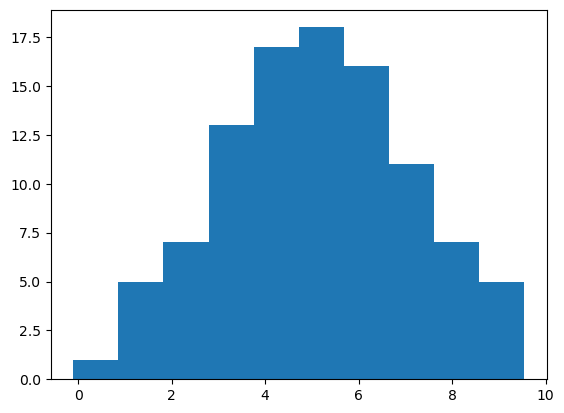

In [1]:
import numpy as np
from scipy import stats, optimize
import matplotlib.pyplot as plt 

# Simulate data
np.random.seed(0)
data = np.random.normal(loc=5.0, scale=2.0, size=100)

plt.hist(data)


## MLE via SciPy Optimize

Define the negative log‐likelihood for μ and σ (we parametrize via log σ for positivity). We can optimize. 


In [2]:
# Negative log-likelihood for Normal
def neg_log_lik(params, x):
    mu, log_sigma = params
    sigma = np.exp(log_sigma)
    # sum of −log pdf = negative log-likelihood
    return -np.sum(stats.norm.logpdf(x, loc=mu, scale=sigma))

In [3]:
# Initial guesses: sample mean & log(sample std)
mu0 = np.mean(data)
log_sigma0 = np.log(np.std(data, ddof=0)) #(ddof is because we need the population MLE, not the unbiased sample estimator which is N-1 don't worry about this)
init = [mu0, log_sigma0]

# Optimize
res = optimize.minimize(
    neg_log_lik,
    x0=init,
    args=(data,),
    method='L-BFGS-B'
)

mu_hat, sigma_hat = res.x[0], np.exp(res.x[1])
print("MLE estimates:")
print("  mu_hat    =", mu_hat)
print("  sigma_hat =", sigma_hat)


MLE estimates:
  mu_hat    = 5.11961603106897
  sigma_hat = 2.0157644894331592


## Bootstrap Confidence Intervals

Resample the data **with replacement**, refit each bootstrap sample, and then take the 2.5th and 97.5th percentiles of the bootstrap estimates.


In [4]:
n_boot = 2000
mu_boots = []
sigma_boots = []

for i in range(n_boot):
    # resample
    samp = np.random.choice(data, size=len(data), replace=True)
    # fit
    res_i = optimize.minimize(
        neg_log_lik,
        x0=init,
        args=(samp,),
        method='L-BFGS-B'
    )
    mu_i, log_sig_i = res_i.x
    mu_boots.append(mu_i)
    sigma_boots.append(np.exp(log_sig_i))

# Compute percentile CIs
alpha = 0.05
lower_mu  = np.percentile(mu_boots, 100 * (alpha/2))
upper_mu  = np.percentile(mu_boots, 100 * (1 - alpha/2))
lower_sig = np.percentile(sigma_boots, 100 * (alpha/2))
upper_sig = np.percentile(sigma_boots, 100 * (1 - alpha/2))

print(f"95% CI for μ: [{lower_mu:.3f}, {upper_mu:.3f}]")
print(f"95% CI for sigma: [{lower_sig:.3f}, {upper_sig:.3f}]")


95% CI for μ: [4.723, 5.524]
95% CI for sigma: [1.740, 2.251]
